In [9]:
# Modelo LSTM
# python3 -m venv env
# source env/bin/activate
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.layers import Input
import joblib
from tensorflow.keras.losses import MeanSquaredError

In [11]:
# Dados fornecidos
# Realizado, Desejado, Felicidade
# se entregou + que o realizado sou + feliz
data = np.array([
    [42, 45, 0.93],
    [55, 55, 1.00],
    [45, 48, 0.93],
    [60, 70, 0.85],
    [69, 70, 0.98],
    [58, 55, 1.05],
    [68, 70, 0.97],
    [71, 60, 1.18],
    [54, 65, 0.83],
    [37, 45, 0.82],
    [55, 50, 1.10]
])

In [12]:
# Escalando os dados
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
print(data_scaled)

[[0.14705882 0.         0.30555556]
 [0.52941176 0.4        0.5       ]
 [0.23529412 0.12       0.30555556]
 [0.67647059 1.         0.08333333]
 [0.94117647 1.         0.44444444]
 [0.61764706 0.4        0.63888889]
 [0.91176471 1.         0.41666667]
 [1.         0.6        1.        ]
 [0.5        0.8        0.02777778]
 [0.         0.         0.        ]
 [0.52941176 0.2        0.77777778]]


In [13]:
# Preparando os dados para o LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        Y.append(data[i + time_step, :])
    return np.array(X), np.array(Y)

# Abu: Testar com 2 ou 3
time_step = 3
X, Y = create_dataset(data_scaled, time_step)

# Verificando as formas dos arrays
print(f'X shape: {X.shape}')  # Esperado: (n_samples, time_steps, n_features)
print(f'Y shape: {Y.shape}')  # Esperado: (n_samples, n_features)

# Reshaping input para [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Dividindo os dados em treinamento e validação
# test_size=0.2 significa 20% para Teste da massa de dados
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.5, random_state=42)


X shape: (7, 3, 3)
Y shape: (7, 3)


In [ ]:
# Criando o modelo LSTM otimizado
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(3))  # Ajuste para Qtd de saídas - Array de 4 colunas tem saida de 4 colunas

#model.compile(optimizer='adam', loss='mse')
model.compile(optimizer='adam', loss=MeanSquaredError())


# Resumo do modelo
# model.summary()

In [14]:
# Treinando o modelo
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=32, verbose=0)


/home/abu/Desenvolvimento/Gabriel/env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# Salvando o modelo treinado no novo formato .keras
model.save('modelo_treinado.keras')

# Salvando o escalador
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [16]:
# Fazendo previsões
predictions = model.predict(X_val)
predictions = scaler.inverse_transform(predictions)

print("Previsões:")
print(predictions)
print()

# Calculando o MAE, MSE e RMSE
mae = mean_absolute_error(scaler.inverse_transform(Y_val), predictions)
mse = mean_squared_error(scaler.inverse_transform(Y_val), predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Previsões:
[[43.840855   46.32506     0.9068416 ]
 [48.10598    50.037457    0.9276825 ]
 [50.82545    49.4652      0.96987385]
 [53.830822   56.11269     0.945852  ]]

Mean Absolute Error (MAE): 8.752920551101367
Mean Squared Error (MSE): 160.56235150435634
Root Mean Squared Error (RMSE): 12.671320037958017


In [17]:
# Convertendo previsões e valores reais para classes (buckets)
def to_class(value, bins):
    return np.digitize(value, bins)

# Definindo intervalos para classificação
bins = [40, 50, 60, 70, 80]
Y_val_classes = np.array([to_class(y, bins) for y in scaler.inverse_transform(Y_val)])
pred_classes = np.array([to_class(y, bins) for y in predictions])

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(Y_val_classes.flatten(), pred_classes.flatten())

print("Matriz de Confusão:")
print(conf_matrix)


Matriz de Confusão:
[[4 0 0 0 0]
 [0 0 0 0 0]
 [0 0 3 0 0]
 [0 3 0 0 0]
 [0 1 1 0 0]]


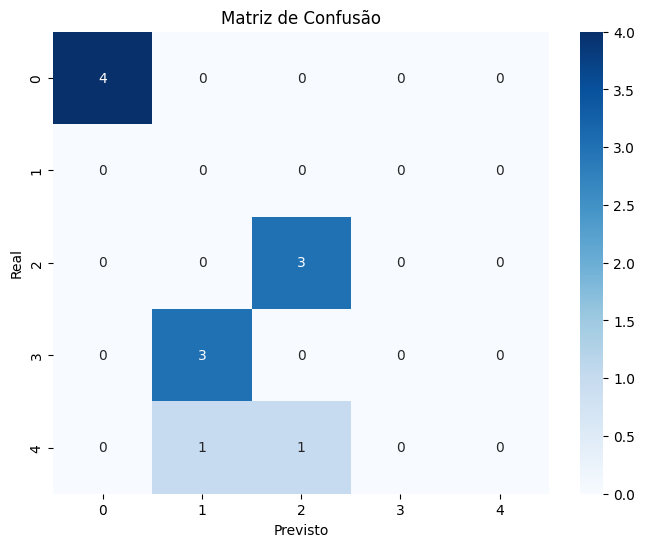

In [18]:
# Plotando a matriz de confusão
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

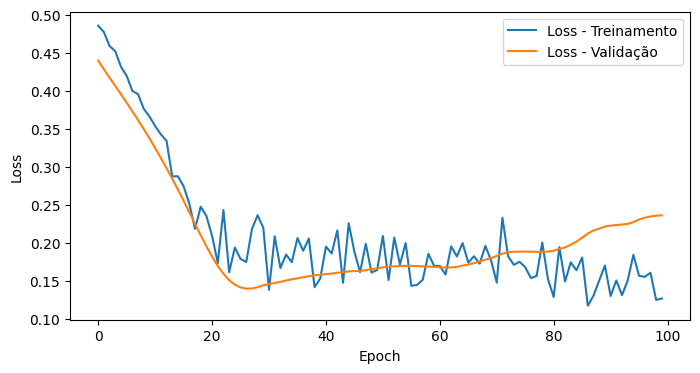

In [19]:
# Plotando o histórico de perda
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Loss - Treinamento')
plt.plot(history.history['val_loss'], label='Loss - Validação')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()